# Data Preprocessing

In [31]:
!pip install -q scikit-optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import moment
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Layer, Dropout, BatchNormalization, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

import warnings
warnings.filterwarnings('ignore')
random_state = 1

In [4]:
data = pd.read_csv("/kaggle/input/eth-all/ETH_return2.csv")
data["timestamp"] = pd.to_datetime(data["timestamp"])
data.set_index("timestamp", inplace=True) # Correcting index format for future plots


split = int(len(data) * 0.8)
train, test = data[:split], data[split:]
scaler = StandardScaler() # Standard instead of MinMax as performance will improve with values outwith min max values in dataset
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test) # Test values scaled using parameters from train data scaling
scaled_data = np.vstack((train_scaled, test_scaled))


column_index = data.columns.get_loc('close') # Retrieves index value of close price
predict_value = 24 # Predicts 24th hour value
SEQ_LENGTH = 24 # Uses sequence of past 24 hours as input

def create_sequences(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length - predict_value):  
        x = data[i:i + seq_length]
        y = data[i + seq_length + predict_value, column_index]  
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)
X, y = create_sequences(scaled_data, SEQ_LENGTH)


# Auto-Encoder HyperParameter Tuning

In [78]:
dimension = 2

def build_autoencoder(dropout_rate=0.2, lstm_units=350, learning_rate=0.01, activation="tanh"):
    lstm_units = int(lstm_units)
    input_layer = Input(shape=(X.shape[1], X.shape[2]))
    
    encoded = LSTM(lstm_units, activation=activation, return_sequences=True)(input_layer)
    encoded = LSTM(dimension, activation=activation, return_sequences=True)(encoded)
    
    decoded = LSTM(lstm_units, return_sequences=True, activation=activation)(encoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = TimeDistributed(Dense(X.shape[2]))(decoded)
    
    model = Model(input_layer, decoded)
    optimizer = AdamW(learning_rate=learning_rate, clip_value=1.0)
    model.compile(optimizer=optimizer, loss=MAE)
    return model


space = [
    Real(0.2, 0.6, name="dropout_rate"),
    Integer(100, 512, name="lstm_units")] # Hyperparameters to tune


@use_named_args(space)
def autoencoder_objective(dropout_rate, lstm_units):
    model = build_autoencoder(dropout_rate=dropout_rate, lstm_units=lstm_units, learning_rate=learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    model.fit(X, X, epochs=40, batch_size=128, validation_split=0.2, callbacks = [early_stopping], verbose=0)
    X_predicted = model.predict(X)
    mse = np.mean(np.power(X - X_predicted, 2), axis=(1, 2))
    return np.mean(mse) # Tuned based on mean squared error


res = gp_minimize(autoencoder_objective, space, n_calls=30)
ae_dropout_rate, ae_lstm_units = res.x

print(f"Dropout Rate: {ae_dropout_rate:.2f}")
print(f"LSTM Units:  {ae_lstm_units:.2f}")

1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1855/1855 ━

# AutoEncoder

In [6]:
input_layer = Input(shape=(X.shape[1], X.shape[2]))

encoded = LSTM(au_lstm_units, activation="tanh", return_sequences=True)(input_layer)
encoded = LSTM(dimension, activation="tanh", return_sequences=True)(encoded)

decoded = LSTM(au_lstm_units, return_sequences=True, activation="tanh")(encoded)
decoded = Dropout(dropout_rate)(decoded)
decoded = TimeDistributed(Dense(X.shape[2]))(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=AdamW(learning_rate=0.01, clip_value=1.0), loss="mae")

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(X, X, epochs=100, batch_size=128, validation_split=0.2, callbacks = [early_stopping])

encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(X)

split = int(len(encoded_data) * 0.8)
encoded_X_train, encoded_X_test = encoded_data[:split], encoded_data[split:] # Encoded data for LSTM model

Epoch 1/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.4405 - val_loss: 0.2137
Epoch 2/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2454 - val_loss: 0.1555
Epoch 3/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2177 - val_loss: 0.1343
Epoch 4/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2041 - val_loss: 0.1277
Epoch 5/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1949 - val_loss: 0.1221
Epoch 6/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1866 - val_loss: 0.1200
Epoch 7/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1816 - val_loss: 0.1093
Epoch 8/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1744 - val_loss: 0.1077
Epoch 9/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1687 - val_loss: 0.0936
Epoch 10/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1616 - val_loss: 0.1105
Epoch 11/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1557 - val_loss: 0.1128
Epoch 12/100
371/371 ━━━━━━━━━

# LSTM HyperParameter Tuning

In [28]:
def build_lstm(lstm_units=12, dropout_rate=0.1, learning_rate=0.001, weight_decay=0.01, 
               regularizer=0.00001, num_layers=2,  momentum=0.9, activation='tanh'):
    
    input_seq = Input(shape=(SEQ_LENGTH, encoded_X_train.shape[2]))
    x = input_seq
    for _ in range(int(num_layers)):
        x = Bidirectional(LSTM(int(lstm_units), return_sequences=True, kernel_regularizer=l2(float(weight_decay)), recurrent_regularizer=l2(float(regularizer))))(x)
        x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(int(lstm_units), return_sequences=False, kernel_regularizer=l2(float(weight_decay)), recurrent_regularizer=l2(float(regularizer))))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    x = Dropout(dropout_rate)(x)
    output = Dense(1)(x)
    
    model = Model(input_seq, output)
    optimizer = AdamW(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss="mse")
    
    return model

space = [
    Integer(4, 128, name='lstm_units'),
    Real(0.05, 0.5, name='dropout_rate'),
    Real(0.001, 0.1, name="weight_decay"),
    Real(0.000001, 0.0001, name="regularizer"),
    Integer(1, 3, name="num_layers")]


@use_named_args(space)
def lstm_objective(**params):
    model = build_lstm(params['lstm_units'], params['dropout_rate'], params["weight_decay"], params["regularizer"], params['num_layers'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    model.fit(encoded_X_train, y_train, epochs=50, validation_split = 0.2, batch_size=128, callbacks = [early_stopping], verbose=0)
    y_pred = model.predict(encoded_X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse


res = gp_minimize(lstm_objective, space, n_calls=30)
lstm_units, dropout_rate, weight_decay, regularizer, num_layers = res.x

print(f"LSTM Units: {lstm_units}")
print(f"Dropout Rate: {dropout_rate:.2f}")
print(f"Weight Decay: {weight_decay:.2f}")
print(f"Regularizer: {regularizer:.2f}")
print(f"Number of Layers: {num_layers}")

371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
371/371 ━━━━━━━━

# LSTM Model

In [27]:
model = build_lstm(lstm_units=lstm_units, dropout_rate=dropout_rate, weight_decay=weight_decay, regularizer=regularizer, num_layers=num_layers)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model.fit(encoded_X_train, y_train, epochs=100, validation_split = 0.2, batch_size=128, callbacks=[early_stopping])

Epoch 1/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 31.6533 - val_loss: 15.7568
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 11.6180 - val_loss: 5.2111
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 3.7780 - val_loss: 1.4390
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 1.0759 - val_loss: 0.3711
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.2809 - val_loss: 0.1005
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0856 - val_loss: 0.0394
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0378 - val_loss: 0.0223
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0266 - val_loss: 0.0178
Epoch 9/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0229 - val_loss: 0.0165
Epoch 10/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0209 - val_loss: 0.0358
Epoch 11/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0178 - val_loss: 0.0285
Epoch 12/100
297/297 ━━━━━

# Evaluation of Predictions

371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


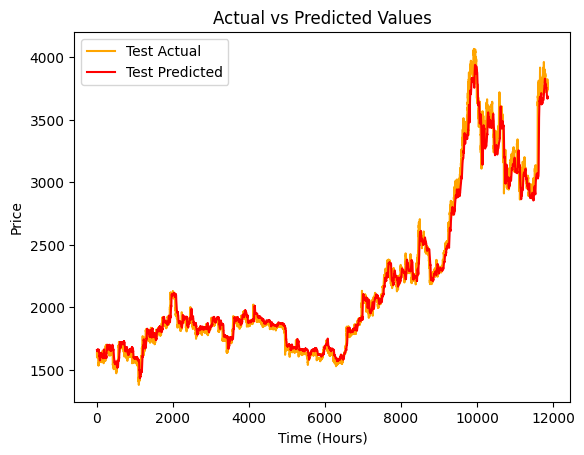

MSE: 7057.450044630538
MAE: 55.41968649899875
MAPE: 2.3827897213049973


In [28]:
test_predictions = model.predict(encoded_X_test)

# This code is here to reset the datasets when running code multple times in one session
X, y = create_sequences(scaled_data, SEQ_LENGTH)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Inverse Scale Values
y_test_partial_reshaped = y_test.reshape(-1, 1)
y_test_reshaped = np.repeat(y_test_partial_reshaped, X_train.shape[2], axis=1)
preds_reshaped = np.repeat(test_predictions, X_train.shape[2], axis=1)
y_pred = scaler.inverse_transform(preds_reshaped)[:,column_index]
y_test = scaler.inverse_transform(y_test_reshaped)[:,column_index]


# Plot Preds vs Targets
plt.plot(y_test, label='Test Actual', color='orange')
plt.plot(y_pred, label='Test Predicted', color='red')
plt.xlabel('Time (Hours)')
plt.ylabel('Price')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


# Metrics
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test, y_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Evaluation of Return Prediction

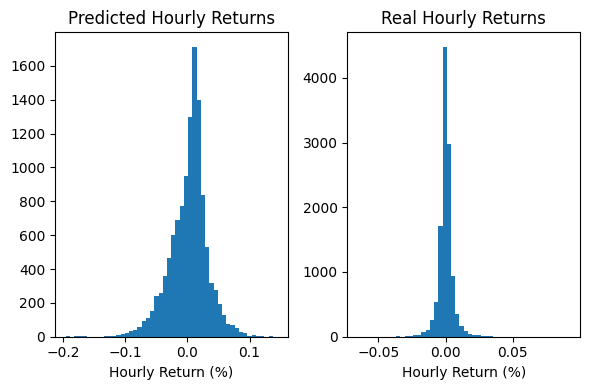

Return MAE: 0.024
Return MSE: 0.001
 
Predicted Return Distribution Moments:
Mean: 0.0, Variance: 1.00, Skewness: -0.70, Kurtosis: 6.06
 
Real Return Distribution Moments
Real Returns: Mean: 0.0, Variance: 1.00, Skewness: -0.06, Kurtosis: 22.81


In [43]:
hours = 1 # Hourly returns

# Real and predicted return values
predicted_return = (y_pred[hours:] / y_test[:-hours]) - 1
real_return = (y_test[hours:] / y_test[:-hours]) - 1

# Plotting Returns Histograms
fig, ax = plt.subplots(1, 2, figsize=(6, 4)) 
ax[0].hist(predicted_return, bins=50)
ax[0].set_title("Predicted Hourly Returns")
ax[0].set_xlabel("Hourly Return (%)")
ax[1].hist(real_return, bins=50)
ax[1].set_title("Real Hourly Returns")
ax[1].set_xlabel("Hourly Return (%)")
plt.tight_layout()
plt.show()

return_mae = mean_absolute_error(real_return, predicted_return)
return_mse = mean_squared_error(real_return, predicted_return)
print(f"Return MAE: {return_mae:.3f}")
print(f"Return MSE: {return_mse:.3f}")

# Normalise data for moment generation
pred_return_nrml = (predicted_return - np.mean(predicted_return)) / np.std(predicted_return)
real_return_nrml = (real_return - np.mean(real_return)) / np.std(real_return)

pred = []
real = []
for i in range(1,5):
    x = moment(pred_return_nrml, moment = i)
    y = moment(real_return_nrml, moment = i)
    pred.append(x)
    real.append(y)

print(" ")
print("Predicted Return Distribution Moments:")
print(f"Mean: {pred[0]}, Variance: {pred[1]:.2f}, Skewness: {pred[2]:.2f}, Kurtosis: {pred[3]:.2f}")
print(" ")
print("Real Return Distribution Moments")
print(f"Real Returns: Mean: {real[0]}, Variance: {real[1]:.2f}, Skewness: {real[2]:.2f}, Kurtosis: {real[3]:.2f}")

**Performance of Price Direction Prediction**

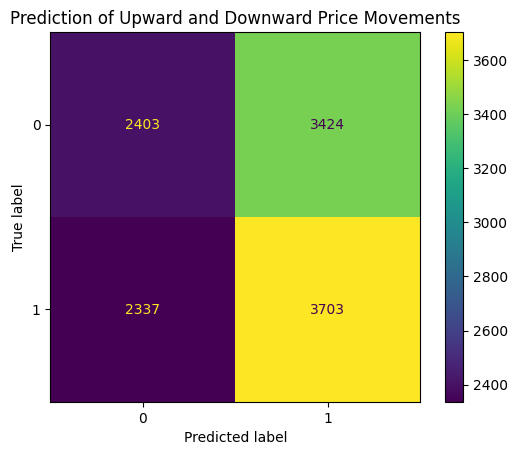

Correctly predicted upward movements percentage (Recall): 0.6130794701986755
Correctly predicted downard movements percentage (Specificity): 0.4123905955036897


In [44]:
# Transforming Preds and Targets to % difference
predicted_direction = []
actual_direction = []

# Transforming preds and targets to 1 if upwards move and 0 if downwards move
for i in range(0, len(y_pred) - 1):
    if y_pred[i + 1] >= y_test[i]:
        predicted_direction.append(1)
    else:
        predicted_direction.append(0)
        
for i in range(0, len(y_test) - 1):
    if y_test[i + 1] >= y_test[i]:
        actual_direction.append(1)
    else:
        actual_direction.append(0)

# Plotting Confusion Matrix
matrix = confusion_matrix(actual_direction, predicted_direction)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.title("Prediction of Upward and Downward Price Movements")
plt.show()


recall = matrix[(1,1)] / (matrix[(1,1)] + matrix[(1,0)])
specificity = matrix[(0,0)] / (matrix[(0,0)] + matrix[(0,1)])

print("Correctly predicted upward movements percentage (Recall):", recall)
print("Correctly predicted downard movements percentage (Specificity):", specificity)

# Trading Algorithm

**VaR (Historical Estimation)**

In [12]:
confidence_level = 0.975
for x in range(24,97,24):
    pct_change = y_test[x:] / y_test[:-x]
    var_hist = 1 - np.percentile(pct_change, (1 - confidence_level) * 100)   
    print(f"{confidence_level * 100}% confident price will not fall more than {var_hist:.2%} in {x} hours")
print(" ")
confidence_level = 0.95
for x in range(24,97,24):
    pct_change = y_test[x:] / y_test[:-x]
    var_hist = 1 - np.percentile(pct_change, (1 - confidence_level) * 100)   
    print(f"{confidence_level * 100}% confident price will not fall more than {var_hist:.2%} in {x} hours")

97.5% confident price will not fall more than 5.34% in 24 hours
97.5% confident price will not fall more than 7.17% in 48 hours
97.5% confident price will not fall more than 8.41% in 72 hours
97.5% confident price will not fall more than 9.57% in 96 hours
 
95.0% confident price will not fall more than 4.04% in 24 hours
95.0% confident price will not fall more than 5.33% in 48 hours
95.0% confident price will not fall more than 6.38% in 72 hours
95.0% confident price will not fall more than 7.47% in 96 hours


**Trading Algorithm**

Strategy Profit: 73.14%
Buy and Hold Profit: 129.49%


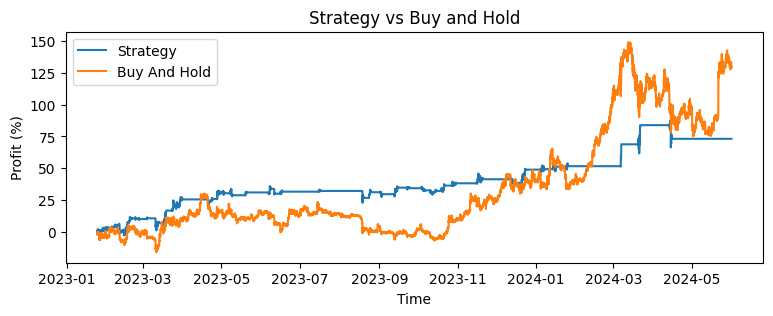

HOLD           11748
BUY               48
TIME SELL         44
PROFIT SELL        4
Name: count, dtype: int64


In [45]:
prices = y_test[:-24]
preds = y_pred[24:]
actual = y_test[24:]

initial_balance = 10000
slippage = 0.0015  # binance trading fee (0.1%) + margin loss (0.05%)
balance = initial_balance
holdings = 0
buy_price = 0
profits = []
portfolio_value = []
actions = []

position_size = 1
take_profit = 1.09
max_hold_time = 72
signal_strength = 1.035

for i in range(len(prices)):

    current_price = prices[i]
    predicted_price = preds[i]
    signal = predicted_price / current_price
    action = "HOLD"
    
    if signal > signal_strength and balance > 0:
        amount_to_invest = balance*position_size
        shares_to_buy = amount_to_invest / current_price
        transaction_cost = shares_to_buy * current_price * slippage
        actual_shares_bought = (amount_to_invest - transaction_cost) / current_price
        holdings += actual_shares_bought
        balance -= amount_to_invest
        buy_price = current_price
        action = 'BUY'   

    elif current_price > buy_price*take_profit and holdings > 0:
            transaction_cost = holdings * current_price * slippage
            balance += (holdings * current_price) - transaction_cost
            profits.append(holdings * (current_price - buy_price) - transaction_cost)
            holdings = 0
            action = "PROFIT SELL"
        
        
    if i % max_hold_time == 0 :
        if holdings > 0:
            transaction_cost = holdings * current_price * slippage
            balance += (holdings * current_price) - transaction_cost
            profits.append(holdings * (current_price - buy_price) - transaction_cost)
            holdings = 0
            action = "TIME SELL"
    

    actions.append(action)  
    portfolio_value.append(balance + (holdings * current_price))

portfolio_value = np.array(portfolio_value)
portfolio = (portfolio_value * 100 / portfolio_value[0]) - 100
strategy_profit = ((portfolio_value[-1] / initial_balance) * 100) - 100

buy_and_hold = (prices * (100 - slippage) / prices[0]) - 100
buy_and_hold_profit = ((prices[-1] / prices[0]) * 100-slippage) - 100 


print(f"Strategy Profit: {strategy_profit:.2f}%")
print(f"Buy and Hold Profit: {buy_and_hold_profit:.2f}%")

index = test.index[predict_value+10:]
plt.figure(figsize=(9, 3))
plt.plot(index, portfolio, label="Strategy")
plt.plot(index, buy_and_hold, label="Buy And Hold") 
plt.xlabel('Time')
plt.ylabel('Profit (%)')
plt.title('Strategy vs Buy and Hold')
plt.legend()
plt.show()

print(pd.Series(actions).value_counts())

# Trading Algorithm Evaluation

We evaluate our algorithm by comparing against a buy and hold strategy. We calculate the annual return, volatility, maximum drawdown and Sharpe ratio of both strategies. We estimate the risk free rate to be the average 1 year T-bill over the trading period. 

In [14]:
!pip install -q pandas pandas_datareader
import pandas_datareader.data as web
from datetime import datetime

df = web.DataReader('GS1', 'fred', datetime(2023, 1, 23),datetime(2024,6,2))
rf_annual = np.mean(df)/100
print(f"Risk Free Rate: {rf_annual}")

Risk Free Rate: 0.05081764705882353


In [46]:
PL_returns = np.diff(np.log(np.array(portfolio_value)))
market_returns = np.diff(np.log(np.array(y_test)))

def calc_max_drawdown(values):
    balances_series = pd.Series(values)
    running_max = balances_series.cummax()
    drawdown = (balances_series - running_max) / running_max
    max_drawdown = drawdown.min()
    return -max_drawdown*100

def calculate_metrics(values, rf):
    annual_return = np.mean(values)*365*24
    volatility = np.std(values)*np.sqrt(365*24)
    max_drawdown = np.max(np.maximum.accumulate(values) - values) / np.max(np.maximum.accumulate(values))
    sharpe_ratio = (annual_return - rf) / volatility
    return volatility, max_drawdown, sharpe_ratio, annual_return

trading_metrics = calculate_metrics(PL_returns,rf_annual)
buy_and_hold_metrics = calculate_metrics(market_returns,rf_annual)
trading_drawdown = calc_max_drawdown(portfolio_value)
buy_and_hold_drawdown = calc_max_drawdown(prices)

# Print metrics
print("Trading Strategy Metrics:")
print(f"Annual Return: {trading_metrics[3]*100:.2f}%")
print(f"Volatility: {trading_metrics[0]:.2f}")
print(f"Maximum Drawdown: {trading_drawdown:.2f}%")
print(f"Sharpe Ratio: {trading_metrics[2]:.2f}")

print("\nBuy and Hold Metrics:")
print(f"Annual Return: {buy_and_hold_metrics[3]*100:.2f}%")
print(f"Volatility: {buy_and_hold_metrics[0]:.2f}")
print(f"Maximum Drawdown: {buy_and_hold_drawdown:.2f}%")
print(f"Sharpe Ratio: {buy_and_hold_metrics[2]:.2f}")

Trading Strategy Metrics:
Annual Return: 40.60%
Volatility: 0.24
Maximum Drawdown: 11.17%
Sharpe Ratio: 1.45

Buy and Hold Metrics:
Annual Return: 61.54%
Volatility: 0.52
Maximum Drawdown: 29.63%
Sharpe Ratio: 1.08
